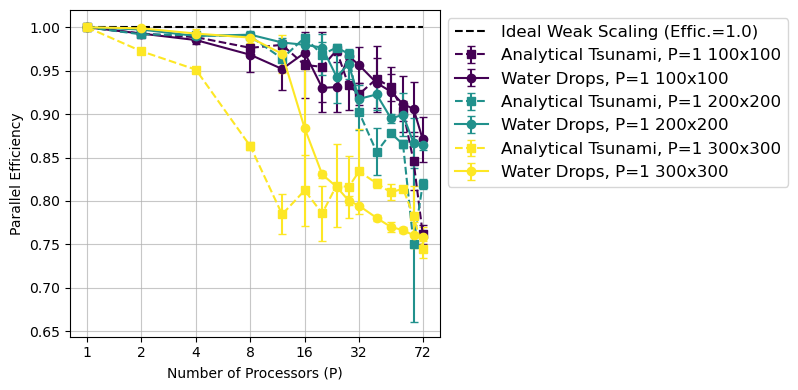

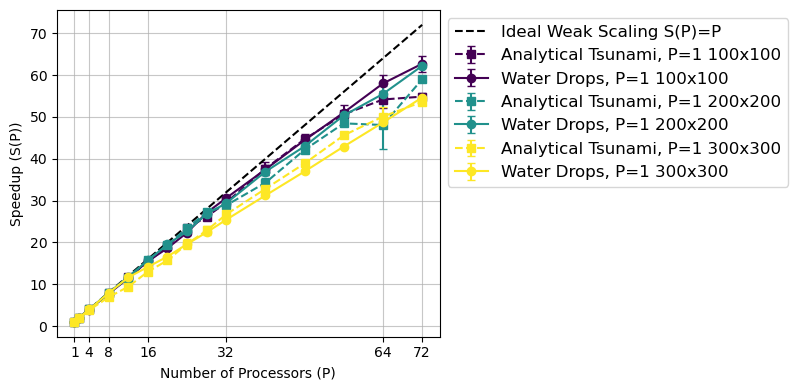

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
# Define file paths and corresponding case names for weak scaling
files_info_weak = {
    'case1': {'path': 'bench_results_weak_scaling/timings_weak_scaling_case1.csv', 'name': 'Water Drops'},
    'case2': {'path': 'bench_results_weak_scaling/timings_weak_scaling_case2.csv', 'name': 'Analytical Tsunami'}
}

all_weak_dfs = []
for case_id, info in files_info_weak.items():
    try:
        df_temp = pd.read_csv(info['path'])
        df_temp['case_name'] = info['name']
        all_weak_dfs.append(df_temp)
    except FileNotFoundError:
        print(f"Warning: File not found: {info['path']}. Skipping {info['name']}.")
        continue

if not all_weak_dfs:
    print("Error: No weak scaling data files found to plot. Please ensure CSV files are in the correct directories.")
else:
    df_combined_weak = pd.concat(all_weak_dfs, ignore_index=True)

    # Ensure 'procs' column is numeric and sorted for plotting
    df_combined_weak['procs'] = pd.to_numeric(df_combined_weak['procs'])
    df_combined_weak = df_combined_weak.sort_values(by=['local_base_size', 'case_name', 'procs'])

    # Get unique local_base_sizes and case_names for iteration
    local_base_sizes = sorted(df_combined_weak['local_base_size'].unique())
    case_names = df_combined_weak['case_name'].unique()

    # Define colors for different local_base_sizes
    colors = plt.cm.viridis(np.linspace(0, 1, len(local_base_sizes)))
    size_color_map = dict(zip(local_base_sizes, colors))

    # Define markers and linestyles for different cases
    case_plot_styles = {
        'Water Drops': {'marker': 'o', 'linestyle': '-'},
        'Analytical Tsunami': {'marker': 's', 'linestyle': '--'}
    }

    # --- 1. Efficiency Plot ---
    plt.figure(figsize=(8, 4))

    for local_size in local_base_sizes:
        for c_name in case_names:
            df_plot = df_combined_weak[
                (df_combined_weak['local_base_size'] == local_size) &
                (df_combined_weak['case_name'] == c_name)
            ].copy()

            if not df_plot.empty:
                grouped_data = df_plot.groupby('procs')['time_per_iteration'].agg(['mean', 'std']).reset_index()

                # Get T1 (time_per_iteration for 1 process for this local_base_size and case)
                if 1 in grouped_data['procs'].values:
                    T1_per_iter = grouped_data[grouped_data['procs'] == 1]['mean'].iloc[0]
                    grouped_data['efficiency'] = T1_per_iter / grouped_data['mean']
                    
                    efficiency_err = grouped_data['efficiency'] * (grouped_data['std'] / grouped_data['mean'])
                    efficiency_err = efficiency_err.fillna(0)

                    color = size_color_map.get(local_size, 'gray')
                    marker = case_plot_styles[c_name]['marker']
                    linestyle = case_plot_styles[c_name]['linestyle']

                    label = f'{c_name}, P=1 {local_size}x{local_size}'
                    plt.errorbar(grouped_data['procs'], grouped_data['efficiency'], 
                                 yerr=efficiency_err, capsize=3, fmt=marker, 
                                 linestyle=linestyle, color=color,
                                 label=label)
                else:
                    print(f"Skipping Efficiency plot for {c_name} {local_size}x{local_size}: No data for P=1.")

    # Plot ideal weak scaling efficiency (constant y=1)
    procs_for_ideal = np.linspace(df_combined_weak['procs'].min(), df_combined_weak['procs'].max(), 100)
    plt.plot(procs_for_ideal, np.ones_like(procs_for_ideal), 'k--', label='Ideal Weak Scaling (Effic.=1.0)')

    plt.xscale('log', base=2)
    # plt.xticks(df_combined_weak['procs'].unique(), [str(p) for p in df_combined_weak['procs'].unique()])
    plt.xticks([1, 2, 4, 8, 16, 32, 72], [str(p) for p in [1, 2, 4, 8, 16, 32, 72]]) # Set xticks from actual procs values
    plt.ylabel('Parallel Efficiency')
    plt.xlabel('Number of Processors (P)')
    # plt.title('Weak Scaling: Parallel Efficiency vs. Number of Processors (Case 1 & 2)')
    plt.grid(True, which='both', ls='-', alpha=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='large')
    plt.tight_layout(rect=[0, 0, 1.01, 1])
    plt.savefig("swe_mpi_weak_scaling_efficiency.pdf")
    plt.show()


    # --- 2. Speedup Plot ---
    plt.figure(figsize=(8, 4))

    for local_size in local_base_sizes:
        for c_name in case_names:
            df_plot = df_combined_weak[
                (df_combined_weak['local_base_size'] == local_size) &
                (df_combined_weak['case_name'] == c_name)
            ].copy()

            if not df_plot.empty:
                grouped_data = df_plot.groupby('procs')['time_per_iteration'].agg(['mean', 'std']).reset_index()

                if 1 in grouped_data['procs'].values:
                    T1_per_iter = grouped_data[grouped_data['procs'] == 1]['mean'].iloc[0]
                    grouped_data['speedup'] = (T1_per_iter / grouped_data['mean']) * grouped_data['procs']
                    
                    # Recalculate efficiency error for this speedup plot's context
                    efficiency_err = (T1_per_iter / grouped_data['mean']) * (grouped_data['std'] / grouped_data['mean'])
                    speedup_err = grouped_data['procs'] * efficiency_err
                    speedup_err = speedup_err.fillna(0)

                    color = size_color_map.get(local_size, 'gray')
                    marker = case_plot_styles[c_name]['marker']
                    linestyle = case_plot_styles[c_name]['linestyle']

                    label = f'{c_name}, P=1 {local_size}x{local_size}'
                    plt.errorbar(grouped_data['procs'], grouped_data['speedup'],
                                 yerr=speedup_err, capsize=3, fmt=marker, 
                                 linestyle=linestyle, color=color,
                                 label=label)
                else:
                    print(f"Skipping Speedup plot for {c_name} {local_size}x{local_size}: No data for P=1.")

    # Plot ideal speedup (Gustafson's Law with a=0, which is S(P) = P)
    procs_for_ideal = np.linspace(df_combined_weak['procs'].min(), df_combined_weak['procs'].max(), 100)
    plt.plot(procs_for_ideal, procs_for_ideal, 'k--', label='Ideal Weak Scaling S(P)=P')

    # plt.xscale('log', base=2)
    # plt.xticks(df_combined_weak['procs'].unique(), [str(p) for p in df_combined_weak['procs'].unique()])
    plt.xticks([1, 4, 8, 16, 32, 64, 72], [str(p) for p in [1, 4, 8, 16, 32, 64, 72]]) # Set xticks from actual procs values
    plt.ylabel('Speedup (S(P))')
    plt.xlabel('Number of Processors (P)')
    # plt.title('Weak Scaling: Speedup vs. Number of Processors (Case 1 & 2)')
    plt.grid(True, which='both', ls='-', alpha=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='large')
    plt.tight_layout(rect=[0, 0, 1.01, 1])
    plt.savefig("swe_mpi_weak_scaling_speedup.pdf")
    plt.show()

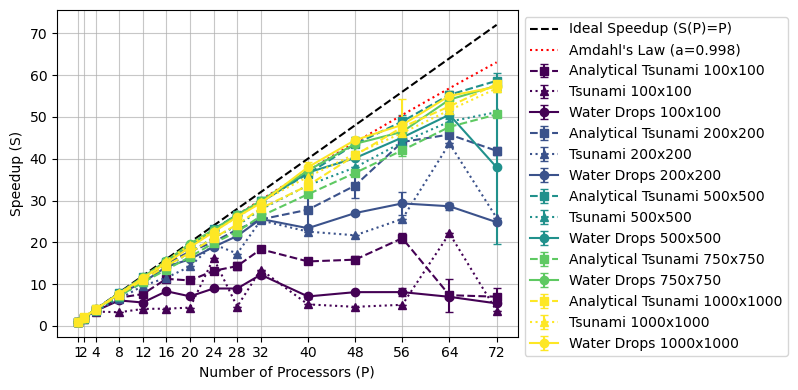

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define file paths and corresponding case names
files_info = {
    'case1': {'path': 'bench_results_case1/timings_case1.csv', 'name': 'Water Drops'},
    'case2': {'path': 'bench_results_case2/timings_case2.csv', 'name': 'Analytical Tsunami'},
    'case3': {'path': 'bench_results_case3/timings_case3.csv', 'name': 'Tsunami'}
}

all_dfs = []
for case_id, info in files_info.items():
    try:
        df_temp = pd.read_csv(info['path'])
        df_temp['case_name'] = info['name']
        all_dfs.append(df_temp)
    except FileNotFoundError:
        print(f"Warning: File not found: {info['path']}. Skipping {info['name']}.")
        continue

if not all_dfs:
    print("Error: No data files found to plot. Please ensure CSV files are in the correct directories.")
else:
    df_combined = pd.concat(all_dfs, ignore_index=True)

    # Ensure 'procs' column is numeric and sorted for plotting
    df_combined['procs'] = pd.to_numeric(df_combined['procs'])
    df_combined = df_combined.sort_values(by=['global_nx', 'global_ny', 'case_name', 'procs'])

    # --- Strong Scaling Speedup Plot (Amdahl's Law) ---

    plt.figure(figsize=(8, 4)) # Increased figure size for better readability with many lines

    # Define a colormap for problem sizes
    # These are the global_nx sizes from your bench_strong_scaling_caseX.sh scripts
    unique_sizes = sorted(df_combined['global_nx'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_sizes))) # Use a colormap for distinct colors
    size_color_map = dict(zip(unique_sizes, colors))

    # Define markers/linestyles for different cases
    case_styles = {
        'Water Drops': {'marker': 'o', 'linestyle': '-'},
        'Analytical Tsunami': {'marker': 's', 'linestyle': '--'},
        'Tsunami': {'marker': '^', 'linestyle': ':'}
    }

    # Define the parallel fraction (f) for Amdahl's Law
    parallel_fraction_f = 0.998 

    # Get all unique combinations of problem size and case name
    unique_plot_groups = df_combined[['global_nx', 'global_ny', 'case_name']].drop_duplicates().values

    # Iterate through each unique group to plot a distinct line
    for nx, ny, case_name in unique_plot_groups:
        # Filter data for current problem size and case
        df_plot_group = df_combined[
            (df_combined['global_nx'] == nx) &
            (df_combined['global_ny'] == ny) &
            (df_combined['case_name'] == case_name)
        ].copy()

        if not df_plot_group.empty:
            # Calculate mean and std for total_time_seconds for each 'procs' group
            grouped_data = df_plot_group.groupby('procs')['total_time_seconds'].agg(['mean', 'std']).reset_index()

            # Ensure there's data for 1 processor to calculate T1_mean
            if 1 in grouped_data['procs'].values:
                T1_mean = grouped_data[grouped_data['procs'] == 1]['mean'].iloc[0]

                # Calculate actual speedup: S(P) = T1 / TP_mean
                grouped_data['speedup'] = T1_mean / grouped_data['mean']
                
                # Calculate error for speedup: dS = S * (std_TP / mean_TP)
                speedup_err = grouped_data['speedup'] * (grouped_data['std'] / grouped_data['mean'])
                speedup_err = speedup_err.fillna(0) # Handle NaN std (e.g., only 1 run)

                # Plot the data
                marker = case_styles[case_name]['marker']
                linestyle = case_styles[case_name]['linestyle']
                color = size_color_map.get(nx, 'gray') # Get color based on global_nx

                label = f'{case_name} {nx}x{ny}'
                plt.errorbar(grouped_data['procs'], grouped_data['speedup'],
                             yerr=speedup_err, capsize=3,
                             fmt=marker, linestyle=linestyle, color=color,
                             label=label)
            else:
                print(f"Skipping plot for {case_name} {nx}x{ny}: No data for P=1 to calculate T1.")

    # Plot Ideal Speedup (S(P) = P)
    procs_min = df_combined['procs'].min()
    procs_max = df_combined['procs'].max()
    procs_for_ideal = np.linspace(procs_min, procs_max, 100)
    plt.plot(procs_for_ideal, procs_for_ideal, 'k--', label='Ideal Speedup (S(P)=P)')

    # Plot Amdahl's Law with parallel_fraction_f
    # S(P) = 1 / ((1-f) + f/P)
    amdahl_speedup = 1 / ((1 - parallel_fraction_f) + parallel_fraction_f / procs_for_ideal)
    plt.plot(procs_for_ideal, amdahl_speedup, 'r:', label=f'Amdahl\'s Law (a={parallel_fraction_f})')

    # Set x-axis to log scale base 2 for processor count
    # plt.xscale('log', base=2)
    # Set xticks to only the actual processor counts from your data for cleaner labels
    plt.xticks(df_combined['procs'].unique(), [str(p) for p in df_combined['procs'].unique()])

    plt.ylabel('Speedup (S)')
    plt.xlabel('Number of Processors (P)')
    # plt.title('Strong Scaling: Speedup vs. Number of Processors (All Cases)')
    plt.grid(True, which='both', ls='-', alpha=0.7)
    
    # Adjust legend position to avoid overlapping with plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)#, fontsize='large')
    plt.tight_layout(rect=[0, 0, 1.01, 1])
    plt.savefig("swe_mpi_strong_scaling.pdf")
    plt.show()

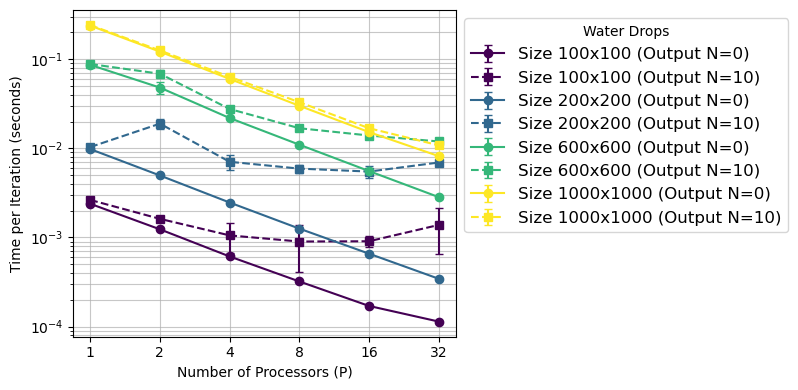

In [18]:



import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("./bench_results_output_overhead/timings_output_overhead.csv")

# Ensure 'procs' column is numeric and sorted for plotting
df['procs'] = pd.to_numeric(df['procs'])
df = df.sort_values(by=['global_nx', 'output_n', 'procs'])

plt.figure(figsize=(8, 4))

# Get unique global_nx sizes to plot separate curves
unique_global_sizes = sorted(df['global_nx'].unique())

# Define a colormap for problem sizes
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_global_sizes)))
size_color_map = dict(zip(unique_global_sizes, colors))

# Define linestyles for with/without writing
output_styles = {
    0: {'linestyle': '-', 'marker': 'o'}, # No output (output_n=0)
    10: {'linestyle': '--', 'marker': 's'} # With output (output_n=10)
}

# Iterate through each global problem size
for g_nx in unique_global_sizes:
    # Iterate through output_n values (0 and 10)
    for out_n in sorted(df['output_n'].unique()):
        # Filter data for the current size and output setting
        df_plot_group = df[(df['global_nx'] == g_nx) & (df['output_n'] == out_n)].copy()

        if not df_plot_group.empty:
            # Calculate mean and std for time_per_iteration for each 'procs' group
            grouped_data = df_plot_group.groupby('procs')['time_per_iteration'].agg(['mean', 'std']).reset_index()
            
            # Get color based on global_nx size
            color = size_color_map.get(g_nx, 'gray')
            # Get linestyle and marker based on output_n
            linestyle = output_styles[out_n]['linestyle']
            marker = output_styles[out_n]['marker']

            # Define label
            label = f'Size {g_nx}x{g_nx} (Output N={out_n})'
            
            # Plot with error bars
            plt.errorbar(grouped_data['procs'], grouped_data['mean'], 
                         yerr=grouped_data['std'], capsize=3, fmt=marker, 
                         linestyle=linestyle, color=color,
                         label=label)

plt.xscale('log', base=2)
plt.yscale('log')
# Set xticks to only the actual processor counts from your data for cleaner labels
plt.xticks(df['procs'].unique(), [str(p) for p in df['procs'].unique()])
plt.ylabel('Time per Iteration (seconds)')
plt.xlabel('Number of Processors (P)')
# plt.title('Output Overhead Effect: Time per Iteration vs. Number of Processors')
plt.grid(True, which='both', ls='-', alpha=0.7)
plt.legend(title=f'Water Drops', loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='large')
plt.tight_layout(rect=[0, 0, 1.01, 1])
plt.savefig("swe_mpi_stong_scaling_outputoverhead.pdf")
plt.show()